# Gradient Boosting (Part I)
## Selecting Model
Man, we've made it so far haha. It's felt like quite a journey so far. This is good. The bright light at the end of the tunnel is ahead. Let's hope, when we reach the other side, the bright light comes from a blazing sun in a bright blue sky with clouds that spell "95% accuracy, good job Chi".

Selecting our model... man... so many that we have at our disposal from when we tried to predict all-NBA teams. Off the top of my head, I think the neural network and gradient boosted trees are probably my best bets because of how non-linear these decision boundaries must be. K-means would probably provide some input but, because of the number of dimensions we have, I'm hesitant that I have enough samples (I dunno, a few million samples ain't bad I guess...). SVMs can also help us map these highly nonlinear decision boundaries, but SVMs are quite slow in their computation, and I'm hesitant that it'll perform better than a neural network. A neural network probably will be slow as well, but I guess I'm just sucked into this "deep learning" craze... well PLUS I think it will ACTUALLY be faster than an SVM haha.

One thing that I'm picking up on is that I'm really not caring about the interpretability of the model. If I were, I'd be looking at the likes of linear regression, LDA, single decision trees... etc. This is something I'm starting to understand more and more through these exercises... There are analytics / ML projects where you really _**care**_ about the model interpretability, and other projects where you care more about _**accuracy**_ and are willing to sacrifice the world in terms of interpretability. Even a very basic neural network with a few hidden layers gets pretty complicated pretty quickly. A random forest more or less loses all its granular interpretability because you literally cannot track it back down to a single tree. You have to get into every single tree and take averages before you can truly understand the inner workings.

I think the nature of some problems are that they are simply so non-linear that you cannot even explain it in a way which humans will comprehend fully. I guess we've reached the crux of human thinking and understanding where we can just sit back in awe and watch the machines take over. Am I glad to be contributing to that? I haven't made up my mind yet haha...

<img src="http://i1.ytimg.com/vi/iyTvTYhZtak/maxresdefault.jpg" style="width: 500px;"/>

Anyways, yeah, let's just go with the neural network and the gradient boosted tree for now.

## Loading Data

In [1]:
# Enable plots in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Seaborn makes our plots prettier
import seaborn
seaborn.set(style = 'ticks')

import numpy as np
import pandas as pd
import random
import itertools

import sklearn

# Set constants
genres_list = [
    'Ambient',
    'Dance',
    'Easy Listening',
    'Folk',
    'Pop',
    'Hip Hop',
    'Jazz',
    'R&B',
    'Rock'
]

In [2]:
# Load the dataset we generated in the previous post
my_itunes_data = pd.read_csv(
    '../features.csv', 
    header = None,
    names = [
        'song_id',
        'title',
        'artist',
        'genre',
        'mfcc_1',
        'mfcc_2',
        'mfcc_3',
        'mfcc_4',
        'mfcc_5',
        'mfcc_6',
        'mfcc_7',
        'mfcc_8',
        'mfcc_9',
        'mfcc_10'
    ]
)

In [3]:
# Check that the data imported properly
my_itunes_data.dtypes

song_id      int64
title       object
artist      object
genre       object
mfcc_1     float64
mfcc_2     float64
mfcc_3     float64
mfcc_4     float64
mfcc_5     float64
mfcc_6     float64
mfcc_7     float64
mfcc_8     float64
mfcc_9     float64
mfcc_10    float64
dtype: object

In [4]:
# Check number of rows in the data set
my_itunes_data.shape[0]

2470678

In [5]:
# Check the number of songs
my_itunes_data['song_id'].nunique()

3825

Okay, so we have around 3825 songs in our data set. Let's use 90% for training and 10% for test. Oh wait, but before I do that, I just realized that I wanted to take out Prince because he was way too difficult to classify and I had way too many Prince songs... A bit of laziness on my part!

In [6]:
# Remove any training samples with "Prince" as artist
my_itunes_data = my_itunes_data[(my_itunes_data['artist'] != 'Prince') & (my_itunes_data['artist'] != 'Prince And The Revolution') & (my_itunes_data['genre'].isin(genres_list))]

# Check the number of songs
my_itunes_data['song_id'].nunique()

3765

I just want to do a quick check of the distribution of songs I have in each genre in my data set.

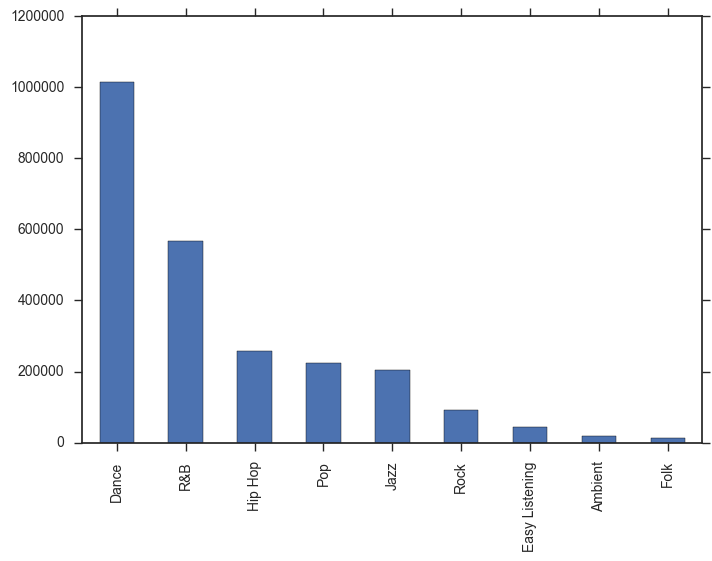

In [7]:
my_itunes_data['genre'].value_counts().plot(kind = 'bar')

Ok, now let's build our training and test sets.

In [8]:
# Get the list of unique song_id's
unique_song_ids = my_itunes_data['song_id'].unique()

# Get ~10% of the test data
test_song_ids = random.sample(unique_song_ids, 380)

# All other songs become the training set
train_song_ids = [x for x in unique_song_ids if x not in test_song_ids]

print 'There are {} songs in the training set and {} songs in the test set'.format(len(train_song_ids), len(test_song_ids))

There are 3385 songs in the training set and 380 songs in the test set


In [9]:
# Build training set
x_train = my_itunes_data[my_itunes_data['song_id'].isin(train_song_ids)].filter(regex = 'mfcc.*').values
y_train = my_itunes_data[my_itunes_data['song_id'].isin(train_song_ids)][['genre']].values.T[0]
print 'There are {} training samples'.format(len(x_train))

# Build test set
x_test = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)].filter(regex = 'mfcc.*').values
y_test = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)][['genre']].values.T[0]
print 'There are {} test samples'.format(len(x_test))

There are 2186438 training samples
There are 245480 test samples


Not quite 10%, but close enough.

## Gradient Boosted Trees
I'll start with GBTs because I flipped a coin in my head and GBT was heads. In my last project where I tried to predict all-NBA players for the 2016 - 2017 season, I used the xgboost package in R. This time, I'm just going to try it in python because I'm already working in here and I feel like it proably would be easier for me to just add sklearn knowledge because of how well python fares in other scenarios (such as having a library for pretty much anything). I won't go over how GBTs are trained again, feel free to refer to my other post if you'd like, but I'll just get started directly here.

In [10]:
# Import xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [11]:
# Encode our labels to integers (e.g. "Dance" becomes a number like 1 or 2)
lb = LabelEncoder()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)
print 'Y (train) set has the following labels {} and has {} elements'.format(np.unique(y_train_encoded), len(y_train_encoded))
print 'Y (test) set has the following labels {} and has {} elements'.format(np.unique(y_test_encoded), len(y_test_encoded))

Y (train) set has the following labels [0 1 2 3 4 5 6 7 8] and has 2186438 elements
Y (test) set has the following labels [0 1 2 3 4 5 6 7 8] and has 245480 elements


In [12]:
# Fit our train and test data to a xgb sparse matrix
xgb_train = xgb.DMatrix(x_train, label = y_train_encoded)
xgb_test = xgb.DMatrix(x_test, label = y_test_encoded)
xgb_test_no_label = xgb.DMatrix(x_test)

In [13]:
# Set xgboost parameters
param = {
    'max_depth': 2,
    'nthread': 2,
    'objective': 'multi:softmax',
    'eval_metric': 'merror',
    'num_class': 9
}

plist = list(param.items())

num_rounds = 10

eval_list  = [(xgb_train, 'train'), (xgb_test, 'eval')]

In [14]:
# Train model
bst = xgb.train(param, xgb_train, num_rounds, eval_list)

[0]	train-merror:0.581557	eval-merror:0.580316
[1]	train-merror:0.581849	eval-merror:0.580569
[2]	train-merror:0.581646	eval-merror:0.580532
[3]	train-merror:0.581584	eval-merror:0.580308
[4]	train-merror:0.581851	eval-merror:0.580532
[5]	train-merror:0.581777	eval-merror:0.580618
[6]	train-merror:0.581711	eval-merror:0.580459
[7]	train-merror:0.581727	eval-merror:0.580471
[8]	train-merror:0.581612	eval-merror:0.580479
[9]	train-merror:0.581587	eval-merror:0.580381


xgboost in python is slightly different, but we get a very similar output. We see our train error and our test error. Here, some intricacies of xgboost for multi-class classification requires us to set the following parameters:
- objective: multi:softmax
- eval_metric: merror
- num_class: 9

Here, I trained for 10 rounds of gradient boosting and it took about 5 minutes. I don't blame it, I guess... It's going through like 2 some odd million samples! This taking a bit longer than I'd have liked for ad-hoc analysis... 10 iterations for 5 minutes... last time when we predicted all-NBA players, I think we were looking at like less than 10K of samples. I remember we had to go to about 130 xgboost iterations. With such a small NBA data set, I could tweak models in a really agile way and get optimal results within seconds. After 10 xgboost iterations here, we don't see our error go down that much... In fact, it really didn't go down at all. I'd love to try more rounds to see if that works, but I'd have to wait 50 minutes if I went to 100 iterations. Even then, the true number of iterations to optimize this classification problem might lie in the multiple hundreds, and I don't want to take out an entire day _**quite yet**_. Realistically, I'm just trying to get a sense of whether or not MFCCs are even a good feature to use for this problem!

Let's take this horrible classifier and look at our test predictions to see if we can even get a sense of what it's doing.

In [15]:
# Predict test
y_test_pred = bst.predict(xgb_test_no_label)
y_test_pred = [int(x) for x in y_test_pred]

This is what the distribution of genres in the test set should look like:

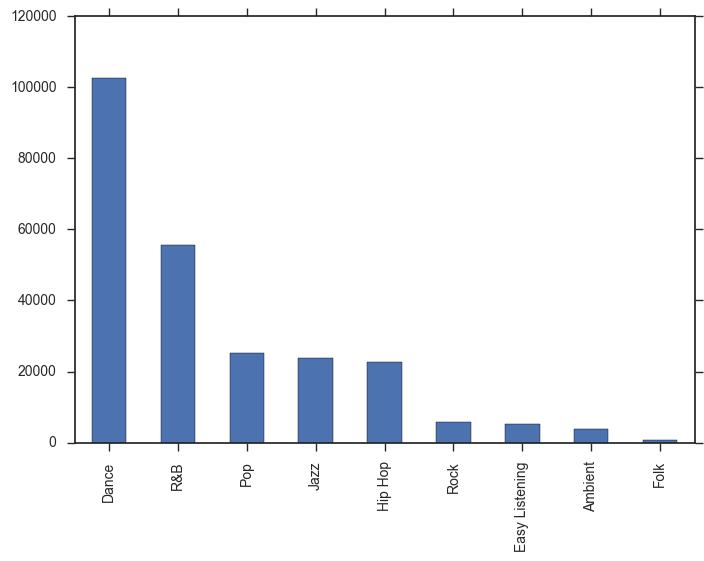

In [16]:
pd.Series(y_test).value_counts().plot(kind = 'bar')

How about our predicted genres?

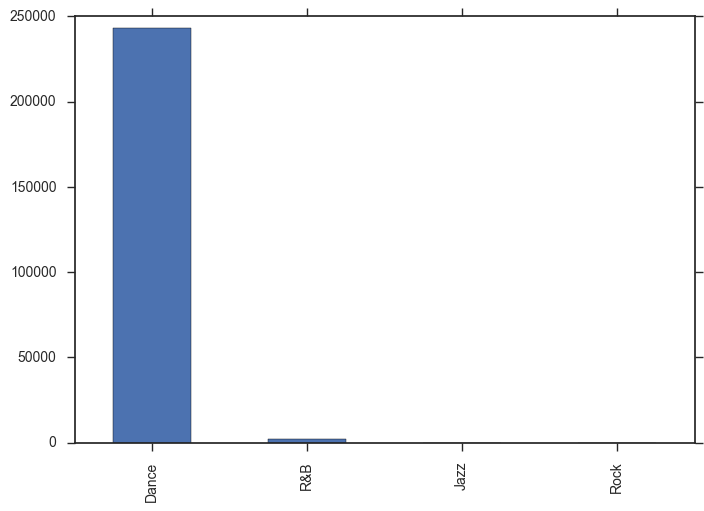

In [17]:
pd.Series(lb.inverse_transform(y_test_pred)).value_counts().plot(kind = 'bar')

Welp, that is a horrible classifier. I can't even believe how horrible this is. It looks like for the most part the classifier just thinks everything is Dance.

In [18]:
print pd.Series(y_test).value_counts()
print ''
print 'There are a total of {} samples in the data set'.format(pd.Series(y_test).value_counts().sum())
print ''
print 'If the classifier always guesses Dance, it will have guessed 107236 / 245208 = {} accuracy'.format(float(107236)/float(245208))

Dance             102714
R&B                55556
Pop                25194
Jazz               23902
Hip Hop            22610
Rock                5814
Easy Listening      5168
Ambient             3876
Folk                 646
dtype: int64

There are a total of 245480 samples in the data set

If the classifier always guesses Dance, it will have guessed 107236 / 245208 = 0.437326677759 accuracy


We see how we're seeing an accuracy of 58% or so. Pretty horrible classifier. Not only does it only guess Dance, when it doesn't guess Dance, it only guessed R&B, Jazz, and Rock. No sign of Hip Hop or Pop, the other genres that are relatively popular in my music library.

However, remember what our _**samples**_ represent! They represent _**frames**_ of songs, not the songs themselves! We have to go back and aggregate and do a majority vote of frames within a song to figure out what genre the _**songs**_ actually are

In [86]:
# Create a new dataframe with just the song ids
x_test_song_id_labels = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)][['song_id']].reset_index(drop = True)

# Append the predicted values to the song ids
x_test_song_id_labels['y_test_pred'] = pd.Series(lb.inverse_transform(y_test_pred))

# Group by and find the most commonly classified genre of each frame per song
song_classification = x_test_song_id_labels.groupby(['song_id'])['y_test_pred'].agg(lambda x: x.value_counts().idxmax()).reset_index()

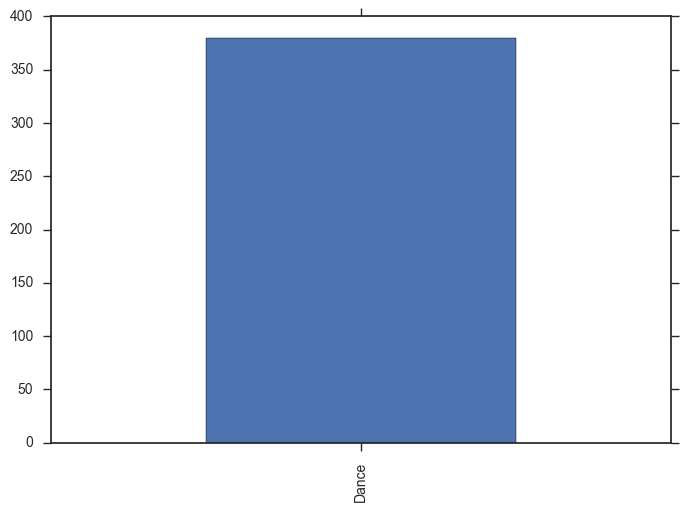

In [87]:
# Plot histogram of predicted song genres
song_classification['y_test_pred'].value_counts().plot(kind = 'bar')

Lol, ok the result is _**even worse**_ when try to aggregate the results back up by song. Literally every single song is predicting Dance. Let's see what the true distribiution of the test set looks like by song.

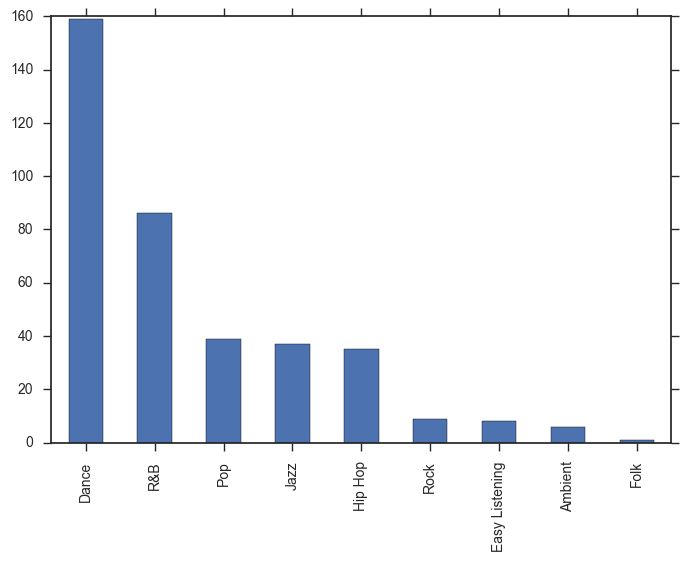

In [92]:
# Filter iTunes data for test set
y_test_song_id_genre = my_itunes_data[my_itunes_data['song_id'].isin(test_song_ids)][['song_id', 'genre']]

# Aggregate by song and plot true test distribution of song genres
y_test_song_id_genre.drop_duplicates()['genre'].value_counts().plot(kind = 'bar')

I don't need a confusion matrix to tell this model is a steaming pile of hot garbage. This is literally trying to emulate what we would do if we had a one track mind and just guessed Dance all the time. Clearly not the model we're looking for. This is probably enough for this post. I'll continue the exploration in the next post.